# exp045

fqidごとのcount

In [4]:
import os
import sys
import traceback
import gc
import random
import pickle
import pathlib
import subprocess
from dataclasses import dataclass
from collections import defaultdict

import pandas as pd
import numpy as np
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss
from sklearn.model_selection import GroupKFold
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
@dataclass
class Cfg:
    mode = "local_cv" # "local_cv" or "kaggle_inf" 
    exp_name = "exp042"
    input_dir = "/mnt/predict-student-performance-from-game-play/input/"
    output_dir = "/mnt/predict-student-performance-from-game-play/output/"
    prep_dir = "/mnt/predict-student-performance-from-game-play/prep/"
    seed = 42
    n_splits = 5
    best_threshold = 0.630 # local_cvの結果を入れる
cfg = Cfg()

if cfg.mode == "local_cv":
    os.makedirs(os.path.join(cfg.output_dir, cfg.exp_name), exist_ok=True)
    os.makedirs(os.path.join(cfg.output_dir, cfg.exp_name, "cache"), exist_ok=True)

elif cfg.mode == "kaggle_inf":
    import jo_wilder

In [6]:
params = {
    'objective': 'binary', 
    'boosting': 'gbdt', 
    'learning_rate': 0.01, 
    'metric': 'binary_logloss', 
    'seed': cfg.seed, 
    'feature_pre_filter': False, 
    'lambda_l1': 4.134488140102331, 
    'lambda_l2': 0.007775200046481757, 
    'num_leaves': 75, 
    'feature_fraction': 0.5, 
    'bagging_fraction': 0.7036110805680353, 
    'bagging_freq': 3, 
    'min_data_in_leaf': 50, 
    'min_child_samples': 100
} 

In [7]:
features_used_total = [
    'record_cnt'
]

In [8]:
level_group_list = ['0-4', '5-12', '13-22']

event_name_list = [
    'cutscene_click', 'person_click', 'navigate_click',
    'observation_click', 'notification_click', 'object_click',
    'object_hover', 'map_hover', 'map_click', 'checkpoint',
    'notebook_click'
]

name_list = [
    'basic', 'undefined', 'close', 'open', 'prev', 'next'
]

page_list = [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0]  

level_list = [ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
               17, 18, 19, 20, 21, 22]

room_fqid_list = ['tunic.historicalsociety.closet',
 'tunic.historicalsociety.basement',
 'tunic.historicalsociety.entry',
 'tunic.historicalsociety.collection',
 'tunic.historicalsociety.stacks',
 'tunic.kohlcenter.halloffame',
 'tunic.capitol_0.hall',
 'tunic.historicalsociety.closet_dirty',
 'tunic.historicalsociety.frontdesk',
 'tunic.humanecology.frontdesk',
 'tunic.drycleaner.frontdesk',
 'tunic.library.frontdesk',
 'tunic.library.microfiche',
 'tunic.capitol_1.hall',
 'tunic.historicalsociety.cage',
 'tunic.historicalsociety.collection_flag',
 'tunic.wildlife.center',
 'tunic.flaghouse.entry',
 'tunic.capitol_2.hall']

fqid_list = [
 'intro',
 'gramps',
 'teddy',
 'photo',
 'notebook',
 'retirement_letter',
 'tobasement',
 'janitor',
 'toentry',
 'groupconvo',
 'report',
 'boss',
 'wells',
 'directory',
 'tocollection',
 'cs',
 'tunic',
 'tunic.hub.slip',
 'tostacks',
 'outtolunch',
 'tocloset',
 'tomap',
 'tunic.historicalsociety',
 'tunic.kohlcenter',
 'plaque',
 'plaque.face.date',
 'togrampa',
 'tunic.capitol_0',
 'chap1_finale',
 'chap1_finale_c',
 'tocloset_dirty',
 'what_happened',
 'trigger_scarf',
 'trigger_coffee',
 'tunic.capitol_1',
 'tofrontdesk',
 'archivist',
 'magnify',
 'tunic.humanecology',
 'worker',
 'businesscards',
 'businesscards.card_0.next',
 'businesscards.card_1.next',
 'businesscards.card_bingo.next',
 'businesscards.card_bingo.bingo',
 'tohallway',
 'tunic.drycleaner',
 'logbook',
 'logbook.page.bingo',
 'tunic.library',
 'tomicrofiche',
 'reader',
 'reader.paper0.next',
 'reader.paper1.next',
 'reader.paper2.bingo',
 'wellsbadge',
 'journals',
 'journals.hub.topics',
 'journals.pic_0.next',
 'journals.pic_1.next',
 'journals.pic_2.bingo',
 'chap2_finale_c',
 'ch3start',
 'seescratches',
 'tocage',
 'glasses',
 'directory.closeup.archivist',
 'key',
 'unlockdoor',
 'confrontation',
 'savedteddy',
 'tocollectionflag',
 'groupconvo_flag',
 'tunic.capitol_2',
 'tunic.wildlife',
 'coffee',
 'crane_ranger',
 'remove_cup',
 'expert',
 'tracks',
 'tracks.hub.deer',
 'tunic.flaghouse',
 'flag_girl',
 'colorbook',
 'reader_flag',
 'reader_flag.paper0.next',
 'reader_flag.paper1.next',
 'reader_flag.paper2.bingo',
 'archivist_glasses',
 'journals_flag',
 'journals_flag.hub.topics_old',
 'journals_flag.hub.topics',
 'journals_flag.pic_0.bingo',
 'journals_flag.pic_0.next',
 'chap4_finale_c',
 'block_tocollection',
 'reader.paper2.next',
 'journals.pic_2.next',
 'lockeddoor',
 'reader.paper2.prev',
 'reader.paper0.prev',
 'reader_flag.paper1.prev',
 'journals_flag.pic_0_old.next',
 'journals_flag.pic_1_old.next',
 'door_block_clean',
 'door_block_talk',
 'block',
 'reader_flag.paper2.next',
 'journals_flag.pic_1.bingo',
 'journals_flag.pic_1.next',
 'journals_flag.pic_2.bingo',
 'journals_flag.pic_2.next',
 'reader_flag.paper0.prev',
 'reader.paper1.prev',
 'block_magnify',
 'journals_flag.pic_2_old.next',
 'block_0',
 'doorblock',
 'block_tomap1',
 'block_tomap2',
 'reader_flag.paper2.prev',
 'need_glasses',
 'block_badge',
 'block_nelson',
 'block_badge_2',
 'block_1',
 'fox'
]

In [9]:
def transform_labels_df(labels_):
    """
    labelsデータを整形する
    """
    labels = labels_.copy()
    labels["question"] = labels["session_id"].apply(lambda x: x.split("_")[1].replace("q", "")).astype(int)
    labels["session_id"] = labels["session_id"].apply(lambda x: x.split("_")[0]).astype(int)
    
    # trainの特徴量と結合するためにquestionに対応するlabel_groupを列として設けておく
    labels["level_group"] = ""
    labels.loc[labels["question"]<=3, "level_group"] = "0-4"
    labels.loc[(labels["question"]>=4)&(labels["question"]<=13), "level_group"] = "5-12"
    labels.loc[labels["question"]>=14, "level_group"] = "13-22"

    return labels

In [10]:
class Features:
    def __init__(self, _sessions):
        self.sessions = _sessions.copy()
        self.features = self.sessions[["session_id", "level_group"]].drop_duplicates().copy()

    def _prep(self):
        self.sessions = self.sessions.sort_values(["session_id", "level_group", "elapsed_time"], ignore_index=True)
        self.sessions["elapsed_time_diff"] = self.sessions["elapsed_time"] - self.sessions.groupby(["session_id", "level_group"])["elapsed_time"].shift(1)

    def _record_cnt(self):
        """level_groupごとのレコード数
        """
        add_features = self.sessions.groupby(["session_id", "level_group"])["index"].count().reset_index().rename(columns={"index":"record_cnt"})
        self.features = self.features.merge(add_features, on=["session_id", "level_group"], how="left")

    def _event_name_record_cnt(self):
        """level_groupごと、各event_nameのレコード数
        """
        add_features = self.sessions.groupby(["session_id", "level_group", "event_name"])["index"].count().reset_index().rename(columns={"index":"cnt"})
        for event in event_name_list:
            new_col = f"{event}_record_cnt"
            tmp = add_features[add_features["event_name"]==event][["session_id", "level_group", "cnt"]].copy()
            if len(tmp) > 0:
                tmp = tmp.rename(columns={"cnt": new_col})
                self.features = self.features.merge(tmp, on=["session_id", "level_group"], how="left")
                self.features[new_col] = self.features[new_col].fillna(-1)
            else:
                self.features[new_col] = -1

    def _name_record_cnt(self):
        """level_groupごと、各nameのレコード数
        """
        add_features = self.sessions.groupby(["session_id", "level_group", "name"])["index"].count().reset_index().rename(columns={"index":"cnt"})
        for name in name_list:
            new_col = f"{name}_record_cnt"
            tmp = add_features[add_features["name"]==name][["session_id", "level_group", "cnt"]].copy()
            if len(tmp) > 0:
                tmp = tmp.rename(columns={"cnt": new_col})
                self.features = self.features.merge(tmp, on=["session_id", "level_group"], how="left")
                self.features[new_col] = self.features[new_col].fillna(-1)
            else:
                self.features[new_col] = -1

    def _page_record_cnt(self):
        """level_groupごと、各pageのレコード数
        """
        add_features = self.sessions.groupby(["session_id", "level_group", "page"])["index"].count().reset_index().rename(columns={"index":"cnt"})
        for page in page_list:
            new_col = f"page{str(int(page))}_cnt"
            tmp = add_features[add_features["page"]==page][["session_id", "level_group", "cnt"]].copy()
            if len(tmp) > 0:
                tmp = tmp.rename(columns={"cnt": new_col})
                self.features = self.features.merge(tmp, on=["session_id", "level_group"], how="left")
                self.features[new_col] = self.features[new_col].fillna(-1)
            else:
                self.features[new_col] = -1

    def _room_fqid_record_cnt(self):
        """level_groupごと、各room_fqidのレコード数
        """
        add_features = self.sessions.groupby(["session_id", "level_group", "room_fqid"])["index"].count().reset_index().rename(columns={"index":"cnt"})
        for room in room_fqid_list:
            new_col = f"{room}_cnt"
            tmp = add_features[add_features["room_fqid"]==room][["session_id", "level_group", "cnt"]].copy()
            if len(tmp) > 0:
                tmp = tmp.rename(columns={"cnt": new_col})
                self.features = self.features.merge(tmp, on=["session_id", "level_group"], how="left")
                self.features[new_col] = self.features[new_col].fillna(-1)
            else:
                self.features[new_col] = -1

    def _fqid_record_cnt(self):
        """level_groupごと、各room_fqidのレコード数
        """
        add_features = self.sessions.groupby(["session_id", "level_group", "fqid"])["index"].count().reset_index().rename(columns={"index":"cnt"})
        for fqid in fqid_list:
            new_col = f"{fqid}_cnt"
            tmp = add_features[add_features["fqid"]==fqid][["session_id", "level_group", "cnt"]].copy()
            if len(tmp) > 0:
                tmp = tmp.rename(columns={"cnt": new_col})
                self.features = self.features.merge(tmp, on=["session_id", "level_group"], how="left")
                self.features[new_col] = self.features[new_col].fillna(-1)
            else:
                self.features[new_col] = -1

    def _level_record_cnt(self):
        """各levelのレコード数
        """
        add_features = self.sessions.groupby(["session_id", "level_group", "level"])["index"].count().reset_index().rename(columns={"index":"cnt"})
        for level in level_list:
            new_col = f"level{str(int(level))}_cnt"
            tmp = add_features[add_features["level"]==level][["session_id", "level_group", "cnt"]].copy()
            if len(tmp) > 0:
                tmp = tmp.rename(columns={"cnt": new_col})
                self.features = self.features.merge(tmp, on=["session_id", "level_group"], how="left")
                self.features[new_col] = self.features[new_col].fillna(-1)
            else:
                self.features[new_col] = -1

    def _elapsed_time(self):
        """level_groupごと、epapsed_timeのmax - min（経過時間）
        """
        add_features = self.sessions.groupby(["session_id", "level_group"])["elapsed_time"].agg([max,min]).reset_index()
        add_features["elapsed_time"] = add_features["max"] - add_features["min"]
        add_features = add_features[["session_id", "level_group", "elapsed_time"]].copy()
        self.features = self.features.merge(add_features, on=["session_id", "level_group"], how="left")

    def _coor_mean(self):
        """level_groupごと、座標系の平均値
        """
        add_features = self.sessions.groupby(["session_id", "level_group"])[["room_coor_x", "room_coor_y", "screen_coor_x", "screen_coor_y"]].mean().reset_index()
        add_features = add_features.rename(columns={"room_coor_x":"room_coor_x_mean", "room_coor_y":"room_coor_y_mean", "screen_coor_x":"screen_coor_x_mean", "screen_coor_y":"screen_coor_y_mean"})
        self.features = self.features.merge(add_features, on=["session_id", "level_group"], how="left")

    def _event_name_coor_mean(self):
        """level_groupごと、evemt_nameごとの座標系の平均値
        """
        coor_cols = ["room_coor_x", "room_coor_y", "screen_coor_x", "screen_coor_y"]
        add_features = self.sessions.groupby(["session_id", "level_group", "event_name"])[coor_cols].mean().reset_index()
        for event in event_name_list:
            if event in ['checkpoint', 'map_hover', 'object_hover']:
                # これらのデータには座標データが存在しないので特徴量化をスキップ
                continue
            col_map = {col:f"{event}_elapsed_{col}_mean" for col in coor_cols}
            new_cols = list(col_map.values())
            tmp = add_features[add_features["event_name"]==event].copy()
            if len(tmp) > 0:
                tmp = tmp.rename(columns=col_map)
                tmp = tmp.drop(columns=["event_name"])
                self.features = self.features.merge(tmp, on=["session_id", "level_group"], how="left")
                self.features[new_cols] = self.features[new_cols].fillna(-1)
            else:
                self.features[new_cols] = -1

    def _name_coor_mean(self):
        """level_groupごと、nameごとの座標系の平均値
        """
        coor_cols = ["room_coor_x", "room_coor_y", "screen_coor_x", "screen_coor_y"]
        add_features = self.sessions.groupby(["session_id", "level_group", "name"])[coor_cols].mean().reset_index()
        for name in name_list:
            col_map = {col:f"{name}_elapsed_{col}_mean" for col in coor_cols}
            new_cols = list(col_map.values())
            tmp = add_features[add_features["name"]==name].copy()
            if len(tmp) > 0:
                tmp = tmp.rename(columns=col_map)
                tmp = tmp.drop(columns=["name"])
                self.features = self.features.merge(tmp, on=["session_id", "level_group"], how="left")
                self.features[new_cols] = self.features[new_cols].fillna(-1)
            else:
                self.features[new_cols] = -1

    def _cat_col_nunique(self, col):
        """level_groupごと、[col]のユニーク数
        """
        add_features = self.sessions.dropna(subset=[col]).drop_duplicates(["session_id", "level_group", col])
        add_features = add_features.groupby(["session_id", "level_group"])["index"].count().reset_index().rename(columns={"index":f"{col}_nunique"})
        self.features = self.features.merge(add_features, on=["session_id", "level_group"], how="left")

    def _elapsed_time_diff_agg(self):
        """level_groupごと、前後のレコードのelapsed_timeの差分に関する集計量
        """
        add_features = self.sessions.copy()
        add_features = add_features.groupby(["session_id", "level_group"])["elapsed_time_diff"].agg(["max", "min", "mean", "std"]).reset_index()
        add_features = add_features.rename(columns={"max":"elapsed_time_diff_max", "min":"elapsed_time_diff_min", "mean":"elapsed_time_diff_mean", "std":"elapsed_time_diff_std"})
        self.features = self.features.merge(add_features, on=["session_id", "level_group"], how="left")

    def _event_name_elapsed_time_diff_agg(self, agg):
        """level_group、event_nameごとelapsed_timeの差分に関する集計量
        """
        add_features = self.sessions.groupby(["session_id", "level_group", "event_name"])["elapsed_time_diff"].agg(agg).reset_index()
        for event in event_name_list:
            col_map = {a:f"{event}_elapsed_time_diff_{a}" for a in agg}
            new_cols = list(col_map.values())
            tmp = add_features[add_features["event_name"]==event].copy()
            if len(tmp) > 0:
                tmp = tmp.rename(columns=col_map)
                tmp = tmp.drop(columns=["event_name"])
                self.features = self.features.merge(tmp, on=["session_id", "level_group"], how="left")
                self.features[new_cols] = self.features[new_cols].fillna(-1)
            else:
                self.features[new_cols] = -1

    def _room_fqid_elapsed_time_diff_agg(self, agg):
        """level_group、room_fqidごとelapsed_timeの差分に関する集計量
        """
        add_features = self.sessions.groupby(["session_id", "level_group", "room_fqid"])["elapsed_time_diff"].agg(agg).reset_index()
        for room in room_fqid_list:
            col_map = {a:f"{room}_elapsed_time_diff_{a}" for a in agg}
            new_cols = list(col_map.values())
            tmp = add_features[add_features["room_fqid"]==room].copy()
            if len(tmp) > 0:
                tmp = tmp.rename(columns=col_map)
                tmp = tmp.drop(columns=["room_fqid"])
                self.features = self.features.merge(tmp, on=["session_id", "level_group"], how="left")
                self.features[new_cols] = self.features[new_cols].fillna(-1)
            else:
                self.features[new_cols] = -1
                
    def _hover_duration_agg(self, agg):
        """level_groupごと、前後のレコードのelapsed_timeの差分に関する集計量
        """
        col_map = {a:f"hover_duration_{a}" for a in agg}
        add_features = self.sessions.copy()
        add_features = add_features.groupby(["session_id", "level_group"])["hover_duration"].agg(agg).reset_index()
        add_features = add_features.rename(columns=col_map)
        self.features = self.features.merge(add_features, on=["session_id", "level_group"], how="left")


    def get_features(self):
        self._prep()
        self._record_cnt()
        self._event_name_record_cnt()
        self._name_record_cnt()
        self._elapsed_time()
        self._coor_mean()
        self._cat_col_nunique("text")
        self._elapsed_time_diff_agg()
        self._event_name_elapsed_time_diff_agg(["mean", "max", "min", "std"])
        self._event_name_coor_mean()
        self._name_coor_mean()
        self._page_record_cnt()
        self._hover_duration_agg(["mean", "max", "min", "std"])
        self._level_record_cnt()
        self._room_fqid_elapsed_time_diff_agg(["mean", "max", "min", "std"])
        self._room_fqid_record_cnt()
        self._fqid_record_cnt()
        return self.features

In [11]:
class History:
    def __init__(self):
        self.store = {}
        for c in features_used_total:
            self.store[c] = defaultdict(int)

    def record(self, train):
        df = train.drop_duplicates("session_id").set_index("session_id")[features_used_total]
        for session in df.index:
            for c in features_used_total:
                self.store[c][session] += df.at[session, c]

    def add_total_features(self, train):
        for c in features_used_total:
            train[f"total_{c}"] = train["session_id"].map(self.store[c])
        return train

In [12]:
def calc_metrics(oof):
    logloss = log_loss(oof["correct"], oof["pred"])

    # find best th
    scores = []; thresholds = []
    best_score = 0; best_threshold = 0

    for threshold in np.arange(0.4,0.81,0.01):
        preds = (oof["pred"].values>threshold).astype(int)
        m = f1_score(oof["correct"].values, preds, average='macro')   
        scores.append(m)
        thresholds.append(threshold)
        if m>best_score:
            best_score = m
            best_threshold = threshold
    print("logloss", format(logloss, ".6f"))
    print("best_score", format(best_score, ".6f"))
    print("best_threshold", format(best_threshold, ".3f"))

    # Q別スコア
    print("---"*10)
    for q in range(18):
        q = q + 1
        preds = (oof[oof["question"]==q]["pred"].values>threshold).astype(int)
        m = f1_score(oof[oof["question"]==q]["correct"].values, preds, average='macro')
        print(f"Q{q} : F1 = {format(m, '.6f')}")
    return best_threshold

In [13]:
def get_train_data(sessions, labels, hist):
    # labelデータの整形
    labels = transform_labels_df(labels)

    # 特徴量生成
    feat = Features(sessions)
    features = feat.get_features()
    
    train = features.merge(labels, on=["session_id", "level_group"], how="left")
    train["level_group"] = train["level_group"].map({"0-4":0, "5-12":1, "13-22":2}).astype("category")
    train["question"] = train["question"].astype("category")

    # level_groupの特徴量記録＆過去のgroup含めたtotal値の特徴量取得
    hist.record(train)
    train = hist.add_total_features(train)

    return train, hist

In [14]:
def run_train():
    dfs = []
    hist = History()
    for group in level_group_list:
        # データ読み込み
        train_sessions = pd.read_csv(cfg.prep_dir + f"train{group}.csv")
        labels = pd.read_csv(cfg.prep_dir + f"train_labels{group}.csv")
        train_group, hist = get_train_data(train_sessions, labels, hist)
        dfs.append(train_group)
    train = pd.concat(dfs, ignore_index=True)
    # concatするとcategory型がリセットされてしまうので再度cast
    train["level_group"] = train["level_group"].astype("category")
    train["question"] = train["question"].astype("category")

    target = "correct"
    not_use_cols = [target, "session_id", "level_group"]
    features = [c for c in train.columns if c not in not_use_cols]

    gkf = GroupKFold(n_splits=cfg.n_splits)
    fis = []
    oofs = []
    for i, (tr_idx, vl_idx) in enumerate(gkf.split(train[features], train[target], train["session_id"])):
        print(f"fold : {i}")
        tr_x, tr_y = train.iloc[tr_idx][features], train.iloc[tr_idx][target]
        vl_x, vl_y = train.iloc[vl_idx][features], train.iloc[vl_idx][target]
        tr_data = lgb.Dataset(tr_x, label=tr_y)
        vl_data = lgb.Dataset(vl_x, label=vl_y)

        model = lgb.train(params, tr_data, valid_sets=[tr_data, vl_data],
                        num_boost_round=2000000, early_stopping_rounds=100, verbose_eval=100)
        # モデル出力
        model.save_model(cfg.output_dir + f"{cfg.exp_name}/{cfg.exp_name}_model{i}.lgb")
        
        # valid_pred
        oof_fold = train.iloc[vl_idx].copy()
        oof_fold["pred"] = model.predict(vl_x, num_iteration=model.best_iteration)
        oofs.append(oof_fold)

        # 特徴量重要度
        fi_fold = pd.DataFrame()
        fi_fold["feature"] = model.feature_name()
        fi_fold["importance"] = model.feature_importance(importance_type="gain")
        fi_fold["fold"] = i
        fis.append(fi_fold)

    fi = pd.concat(fis)    
    fi_n = fi['feature'].nunique()
    order = list(fi.groupby("feature").mean().sort_values("importance", ascending=False).index)
    plt.figure(figsize=(10, fi_n*0.2))
    sns.barplot(x="importance", y="feature", data=fi, order=order)
    plt.title(f"LGBM importance")
    plt.tight_layout()
    plt.savefig(cfg.output_dir + f'{cfg.exp_name}/lgbm_importance.png')

    # cv
    oof = pd.concat(oofs)
    best_threshold = calc_metrics(oof)
    cfg.best_threshold = best_threshold
    oof.to_csv(cfg.output_dir + f"{cfg.exp_name}/oof.csv.gz", compression="gzip", index=False)

In [15]:
def get_mock_iter_test():
    test = pd.read_csv(cfg.input_dir + "test.csv")
    sub = pd.read_csv(cfg.input_dir + "sample_submission.csv")
    tests = [df[1].drop(columns="session_level").reset_index(drop=True) for df in test.groupby("session_level")]
    subs = [df[1].drop(columns="session_level").reset_index(drop=True) for df in sub.groupby("session_level")]
    return zip(subs, tests)

In [16]:
def inference(mode):
    if mode == "local_cv":
        # time series apiを模したiterをモックとして用意する
        iter_test = get_mock_iter_test()
    elif mode == "kaggle_inf":
        env = jo_wilder.make_env()
        iter_test = env.iter_test()
        
    models = []
    for i in range(cfg.n_splits):
        if mode == "local_cv":
            model_path = cfg.output_dir + f"{cfg.exp_name}/{cfg.exp_name}_model{i}.lgb"
        elif mode == "kaggle_inf":
            model_path = f"/kaggle/input/jo-wilder-{cfg.exp_name}/{cfg.exp_name}_model{i}.lgb"
        models.append(lgb.Booster(model_file=model_path))
    
    hist = History()
    for (sample_submission, test_sessions) in iter_test:
        test, hist = get_train_data(test_sessions, sample_submission, hist)
        preds = np.zeros(len(test))
        for i in range(cfg.n_splits):
            model = models[i]
            features = model.feature_name()
            preds += model.predict(test[features], num_iteration=model.best_iteration) / cfg.n_splits
        preds = (preds>cfg.best_threshold).astype(int)
        sample_submission["correct"] = preds

        if mode == "local_cv":
            print(sample_submission["correct"].values)
        elif mode == "kaggle_inf":
            env.predict(sample_submission)

/tmp/ipykernel_28621/468930492.py:84: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.features[new_col] = -1
/tmp/ipykernel_28621/468930492.py:84: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.features[new_col] = -1
/tmp/ipykernel_28621/468930492.py:84: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.cop

fold : 0


/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=100 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=100 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Info] Number of positive: 119434, number of negative: 50180
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.110658 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 62241
[LightGBM] [Info] Number of data points in the train set: 169614, number of used features: 386
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=100 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.704152 -> initscore=0.867147
[LightGBM] [Info] Start training from score 0.867147


/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.531774	valid_1's binary_logloss: 0.53543
[200]	training's binary_logloss: 0.50118	valid_1's binary_logloss: 0.508515
[300]	training's binary_logloss: 0.485901	valid_1's binary_logloss: 0.497369
[400]	training's binary_logloss: 0.476214	valid_1's binary_logloss: 0.492009
[500]	training's binary_logloss: 0.468767	valid_1's binary_logloss: 0.488977
[600]	training's binary_logloss: 0.462642	valid_1's binary_logloss: 0.48716
[700]	training's binary_logloss: 0.457353	valid_1's binary_logloss: 0.485944
[800]	training's binary_logloss: 0.452561	valid_1's binary_logloss: 0.485185
[900]	training's binary_logloss: 0.448088	valid_1's binary_logloss: 0.484657
[1000]	training's binary_logloss: 0.44384	valid_1's binary_logloss: 0.484221
[1100]	training's binary_logloss: 0.439847	valid_1's binary_logloss: 0.483875
[1200]	training's binary_logloss: 0.436123	valid_1's binary_logloss: 0.483595
[1300]	training

/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=100 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=100 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Info] Number of positive: 119268, number of negative: 50346
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.110936 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 62192
[LightGBM] [Info] Number of data points in the train set: 169614, number of used features: 386
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=100 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.703173 -> initscore=0.862454
[LightGBM] [Info] Start training from score 0.862454


/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.53152	valid_1's binary_logloss: 0.53472
[200]	training's binary_logloss: 0.500365	valid_1's binary_logloss: 0.509487
[300]	training's binary_logloss: 0.484849	valid_1's binary_logloss: 0.499507
[400]	training's binary_logloss: 0.475048	valid_1's binary_logloss: 0.494976
[500]	training's binary_logloss: 0.467555	valid_1's binary_logloss: 0.49251
[600]	training's binary_logloss: 0.461465	valid_1's binary_logloss: 0.49103
[700]	training's binary_logloss: 0.456109	valid_1's binary_logloss: 0.490164
[800]	training's binary_logloss: 0.451295	valid_1's binary_logloss: 0.489647
[900]	training's binary_logloss: 0.446818	valid_1's binary_logloss: 0.489342
[1000]	training's binary_logloss: 0.442573	valid_1's binary_logloss: 0.489025
[1100]	training's binary_logloss: 0.438595	valid_1's binary_logloss: 0.488825
[1200]	training's binary_logloss: 0.434836	valid_1's binary_logloss: 0.48867
[1300]	training'

/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=100 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=100 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Info] Number of positive: 119502, number of negative: 50112
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.101901 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 62344
[LightGBM] [Info] Number of data points in the train set: 169614, number of used features: 386
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=100 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.704553 -> initscore=0.869073
[LightGBM] [Info] Start training from score 0.869073


/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.530119	valid_1's binary_logloss: 0.540549
[200]	training's binary_logloss: 0.499148	valid_1's binary_logloss: 0.515008
[300]	training's binary_logloss: 0.483784	valid_1's binary_logloss: 0.504681
[400]	training's binary_logloss: 0.473957	valid_1's binary_logloss: 0.499754
[500]	training's binary_logloss: 0.466446	valid_1's binary_logloss: 0.496805
[600]	training's binary_logloss: 0.46034	valid_1's binary_logloss: 0.495057
[700]	training's binary_logloss: 0.455007	valid_1's binary_logloss: 0.493976
[800]	training's binary_logloss: 0.450213	valid_1's binary_logloss: 0.493298
[900]	training's binary_logloss: 0.445724	valid_1's binary_logloss: 0.492834
[1000]	training's binary_logloss: 0.441488	valid_1's binary_logloss: 0.492475
[1100]	training's binary_logloss: 0.437566	valid_1's binary_logloss: 0.492213
[1200]	training's binary_logloss: 0.433764	valid_1's binary_logloss: 0.492017
[1300]	train

/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=100 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=100 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Info] Number of positive: 119476, number of negative: 50138
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.115895 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 62296
[LightGBM] [Info] Number of data points in the train set: 169614, number of used features: 386
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=100 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.704399 -> initscore=0.868336
[LightGBM] [Info] Start training from score 0.868336


/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.530844	valid_1's binary_logloss: 0.538013
[200]	training's binary_logloss: 0.499936	valid_1's binary_logloss: 0.511995
[300]	training's binary_logloss: 0.484557	valid_1's binary_logloss: 0.501325
[400]	training's binary_logloss: 0.474704	valid_1's binary_logloss: 0.496342
[500]	training's binary_logloss: 0.46723	valid_1's binary_logloss: 0.493447
[600]	training's binary_logloss: 0.461099	valid_1's binary_logloss: 0.491933
[700]	training's binary_logloss: 0.455747	valid_1's binary_logloss: 0.490961
[800]	training's binary_logloss: 0.450921	valid_1's binary_logloss: 0.490431
[900]	training's binary_logloss: 0.44642	valid_1's binary_logloss: 0.489951
[1000]	training's binary_logloss: 0.442206	valid_1's binary_logloss: 0.489692
[1100]	training's binary_logloss: 0.438205	valid_1's binary_logloss: 0.489472
[1200]	training's binary_logloss: 0.434442	valid_1's binary_logloss: 0.489326
[1300]	traini

/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=100 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=100 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Info] Number of positive: 119328, number of negative: 50304
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.086430 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 62229
[LightGBM] [Info] Number of data points in the train set: 169632, number of used features: 386
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=100 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.703452 -> initscore=0.863791
[LightGBM] [Info] Start training from score 0.863791


/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.530825	valid_1's binary_logloss: 0.537145
[200]	training's binary_logloss: 0.49983	valid_1's binary_logloss: 0.511935
[300]	training's binary_logloss: 0.484465	valid_1's binary_logloss: 0.501764
[400]	training's binary_logloss: 0.474712	valid_1's binary_logloss: 0.496888
[500]	training's binary_logloss: 0.467293	valid_1's binary_logloss: 0.494001
[600]	training's binary_logloss: 0.461207	valid_1's binary_logloss: 0.492403
[700]	training's binary_logloss: 0.455846	valid_1's binary_logloss: 0.491386
[800]	training's binary_logloss: 0.451038	valid_1's binary_logloss: 0.490653
[900]	training's binary_logloss: 0.446593	valid_1's binary_logloss: 0.490114
[1000]	training's binary_logloss: 0.442411	valid_1's binary_logloss: 0.48975
[1100]	training's binary_logloss: 0.43846	valid_1's binary_logloss: 0.489421
[1200]	training's binary_logloss: 0.434705	valid_1's binary_logloss: 0.489251
[1300]	trainin

/tmp/ipykernel_28621/468930492.py:84: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.features[new_col] = -1
/tmp/ipykernel_28621/468930492.py:84: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.features[new_col] = -1
/tmp/ipykernel_28621/468930492.py:84: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.cop

[1 1 1]


/tmp/ipykernel_28621/468930492.py:84: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.features[new_col] = -1
/tmp/ipykernel_28621/468930492.py:84: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.features[new_col] = -1
/tmp/ipykernel_28621/468930492.py:84: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.cop

[1 0 1 1 1]


/tmp/ipykernel_28621/468930492.py:84: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.features[new_col] = -1
/tmp/ipykernel_28621/468930492.py:84: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.features[new_col] = -1
/tmp/ipykernel_28621/468930492.py:84: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.cop

[1 0 1 1 0 1 0 0 1 0]


/tmp/ipykernel_28621/468930492.py:84: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.features[new_col] = -1
/tmp/ipykernel_28621/468930492.py:84: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.features[new_col] = -1
/tmp/ipykernel_28621/468930492.py:84: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.cop

[0 1 1]


/tmp/ipykernel_28621/468930492.py:84: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.features[new_col] = -1
/tmp/ipykernel_28621/468930492.py:84: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.features[new_col] = -1
/tmp/ipykernel_28621/468930492.py:84: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.cop

[1 0 1 1 1]


/tmp/ipykernel_28621/468930492.py:84: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.features[new_col] = -1
/tmp/ipykernel_28621/468930492.py:84: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.features[new_col] = -1
/tmp/ipykernel_28621/468930492.py:84: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.cop

[0 0 0 0 0 0 0 0 1 0]


/tmp/ipykernel_28621/468930492.py:84: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.features[new_col] = -1
/tmp/ipykernel_28621/468930492.py:84: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.features[new_col] = -1
/tmp/ipykernel_28621/468930492.py:84: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.cop

[1 1 1]


/tmp/ipykernel_28621/468930492.py:84: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.features[new_col] = -1
/tmp/ipykernel_28621/468930492.py:84: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.features[new_col] = -1
/tmp/ipykernel_28621/468930492.py:84: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.cop

[1 0 1 1 1]


/tmp/ipykernel_28621/468930492.py:84: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.features[new_col] = -1
/tmp/ipykernel_28621/468930492.py:84: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.features[new_col] = -1
/tmp/ipykernel_28621/468930492.py:84: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.cop

[1 1 1 1 1 1 1 1 1 0]


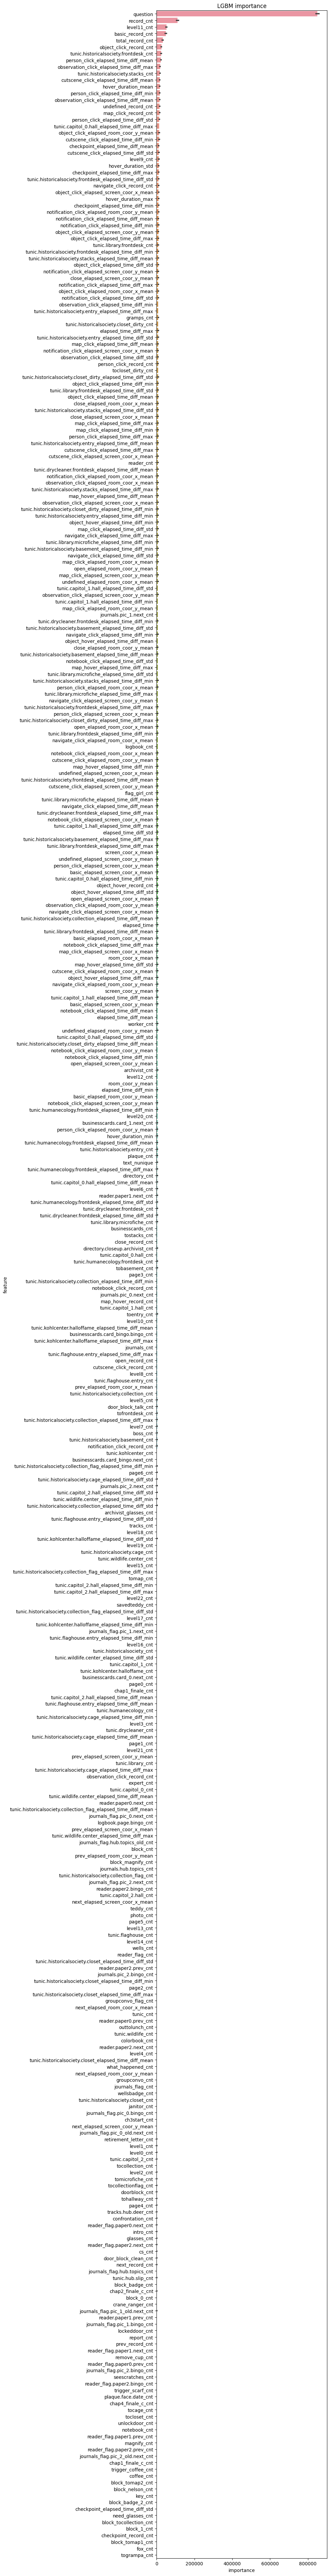

In [17]:
if cfg.mode == "local_cv":
    run_train()
inference(cfg.mode)